In [1]:
audio_path = f'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen = f'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

Mel-Frequency Cepstral Coefficients (MFCCs)

In [2]:
import numpy as np
import scipy.fftpack as fftpack
import scipy.signal as signal
import librosa

def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Bước 1: Pre-emphasis - Lọc thông cao
    """
    emphasized_signal = np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1]) # y(t) = x(t) - alpha*x(t-1)
    return emphasized_signal

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Bước 2: Chia khung (Framing)
    - frame_size: kích thước khung (số giây)
    - frame_stride: bước nhảy giữa các khung (số giây)
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    # Zero-padding nếu cần
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Bước 3: Áp dụng cửa sổ Hamming cho mỗi khung
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    windowed_frames = frames * hamming
    return windowed_frames

def fft_frames(frames, NFFT=512):
    """
    Bước 4: Tính FFT cho mỗi khung
    """
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    return mag_frames

def power_spectrum(mag_frames, NFFT=512):
    """
    Bước 4.1: Tính phổ công suất của mỗi khung
    """
    return (1.0 / NFFT) * (mag_frames ** 2)

def mel_filterbank(sample_rate, NFFT, nfilt=26, low_freq=0, high_freq=None):
    """
    Bước 5: Tạo Mel filterbank
    """
    if high_freq is None:
        high_freq = sample_rate / 2

    # Chuyển Hz sang Mel
    low_mel = 2595 * np.log10(1 + low_freq / 700.0)
    high_mel = 2595 * np.log10(1 + high_freq / 700.0)
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    # Chuyển lại từ Mel sang Hz
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # giới hạn trái
        f_m = int(bin[m])             # trung tâm
        f_m_plus = int(bin[m + 1])    # giới hạn phải

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

def compute_mfcc(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, 
                 pre_emph=0.97, NFFT=512, nfilt=26, num_ceps=13):
    """
    Hàm tích hợp các bước tính MFCC:
      1. Pre-emphasis
      2. Framing
      3. Windowing
      4. FFT và Power Spectrum
      5. Áp dụng Mel Filterbank
      6. Logarithm
      7. DCT để thu MFCCs
    """
    # Bước 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal_in, pre_emph)

    # Bước 2: Framing
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)

    # Bước 3: Windowing
    windowed_frames = windowing(frames)

    # Bước 4: FFT và Power Spectrum
    mag_frames = fft_frames(windowed_frames, NFFT)
    pow_frames = power_spectrum(mag_frames, NFFT)

    # Bước 5: Mel Filterbank
    fbank = mel_filterbank(sample_rate, NFFT, nfilt)
    filter_banks = np.dot(pow_frames, fbank.T)
    # Tránh log(0)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)

    # Bước 6: Lấy logarithm của năng lượng trên mỗi dải Mel
    log_fbank = np.log(filter_banks)

    # Bước 7: DCT (Discrete Cosine Transform) để thu được MFCCs
    mfccs = fftpack.dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfccs



In [3]:
signal_in, sr = librosa.load(audio_path, sr=None)
signal_in_queen, sr_queen = librosa.load(audio_path_queen, sr=None)

mfcc_features = compute_mfcc(signal_in, sr)
mfcc_features_queen = compute_mfcc(signal_in_queen, sr_queen)

print("Kích thước MFCC:", mfcc_features.shape)

Kích thước MFCC: (199, 13)


In [4]:
import numpy as np

distance = np.linalg.norm(mfcc_features - mfcc_features_queen)
print(distance)


362.02187322908054


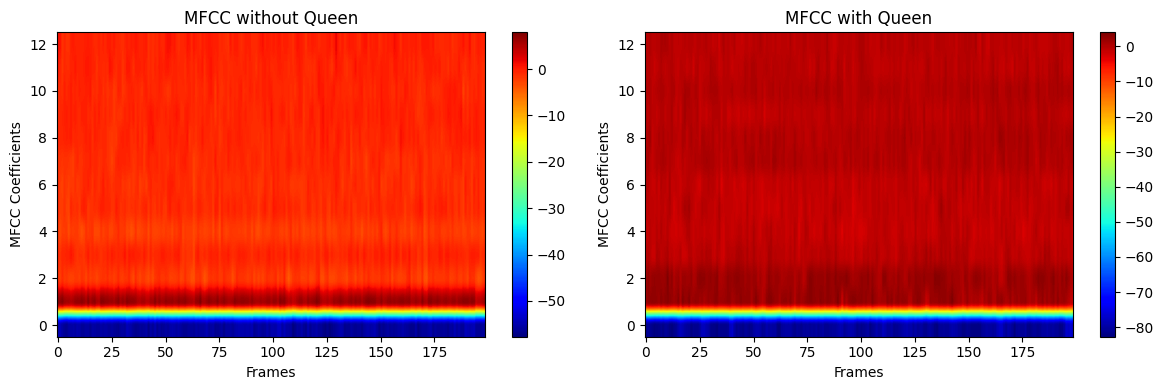

In [5]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cax1 = ax1.imshow(mfcc_features.T, cmap='jet', aspect='auto', origin='lower')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('MFCC without Queen')
ax1.set_xlabel('Frames')
ax1.set_ylabel('MFCC Coefficients')

cax2 = ax2.imshow(mfcc_features_queen.T, cmap='jet', aspect='auto', origin='lower')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('MFCC with Queen')
ax2.set_xlabel('Frames')
ax2.set_ylabel('MFCC Coefficients')

plt.tight_layout()

plt.show()


Short-Time Fourier Transform (STFT)

In [6]:
from scipy.signal import stft, get_window

def compute_stft(signal_in, sample_rate, window_size=2048, hop_size=512, window_type='hann'):
    """
    Hàm tính Short-Time Fourier Transform (STFT) của tín hiệu âm thanh.
    
    Args:
    - signal_in: Tín hiệu âm thanh đầu vào (mảng numpy)
    - sample_rate: Tỷ lệ lấy mẫu của tín hiệu (Hz)
    - window_size: Kích thước cửa sổ (số mẫu)
    - hop_size: Bước nhảy giữa các khung (số mẫu)
    - window_type: Loại cửa sổ sử dụng ('hann', 'hamming', v.v.)

    Returns:
    - Zxx: Kết quả STFT (biến đổi Fourier trong miền thời gian-tần số)
    """
    # Áp dụng cửa sổ vào tín hiệu
    window = get_window(window_type, window_size)
    
    # Tính toán STFT bằng hàm scipy.signal.stft
    f, t, Zxx = stft(signal_in, fs=sample_rate, window=window, nperseg=window_size, noverlap=hop_size)
    
    return f, t, Zxx


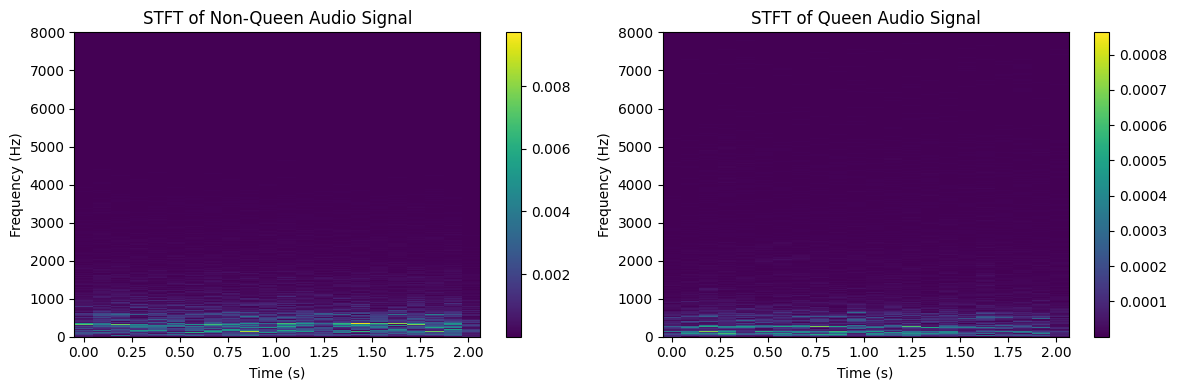

In [7]:
def plot_stft_side_by_side(f_nonqueen, t_nonqueen, Zxx_nonqueen, f_queen, t_queen, Zxx_queen):
    """
    Hàm để vẽ biểu đồ STFT (Time-Frequency Spectrogram).
    
    Args:
    - f: Tần số
    - t: Thời gian
    - Zxx: Kết quả STFT
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    cax1 = ax1.pcolormesh(t_nonqueen, f_nonqueen, np.abs(Zxx_nonqueen), shading='auto')
    fig.colorbar(cax1, ax=ax1)
    ax1.set_title('STFT of Non-Queen Audio Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')

    # Plot STFT for Queen signal
    cax2 = ax2.pcolormesh(t_queen, f_queen, np.abs(Zxx_queen), shading='auto')
    fig.colorbar(cax2, ax=ax2)
    ax2.set_title('STFT of Queen Audio Signal')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

signal_in_nonqueen, sr_nonqueen = librosa.load(audio_path, sr=None)
signal_in_queen, sr_queen = librosa.load(audio_path_queen, sr=None)

f_nonqueen, t_nonqueen, Zxx_nonqueen = compute_stft(signal_in_nonqueen, sr_nonqueen)

f_queen, t_queen, Zxx_queen = compute_stft(signal_in_queen, sr_queen)
plot_stft_side_by_side(f_nonqueen, t_nonqueen, Zxx_nonqueen, f_queen, t_queen, Zxx_queen)


Fast Fourier Transform (FFT)

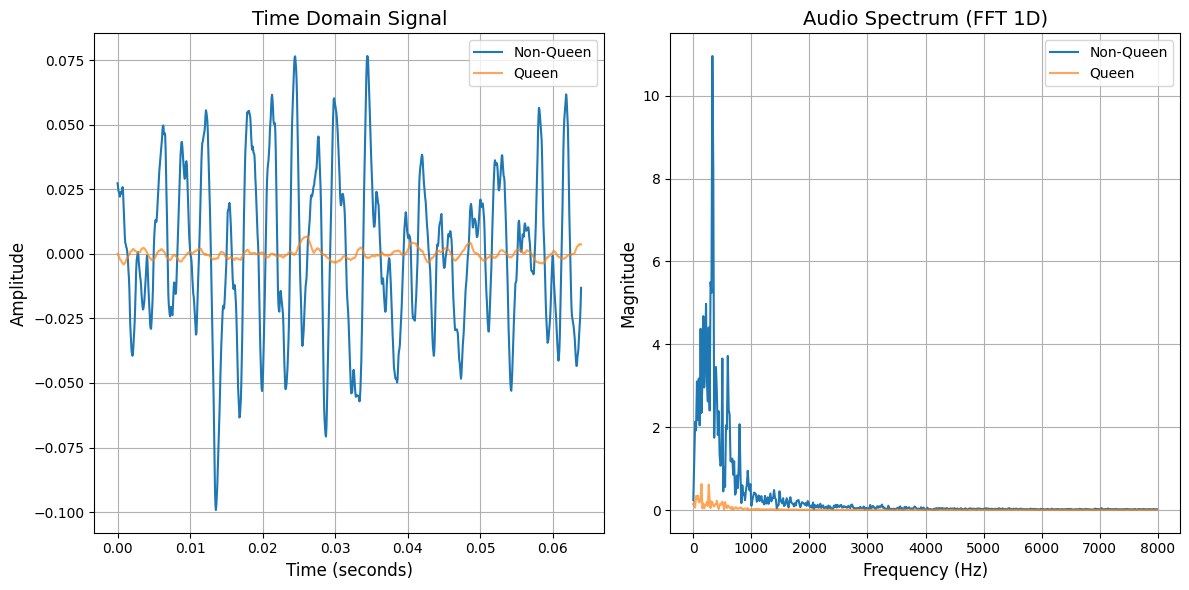

In [8]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Hàm FFT 1D
def fft_1d(x):
    N = len(x)
    if N <= 1:
        return x
    
    # Chia tín hiệu thành các phần chẵn và lẻ
    even = fft_1d(x[::2])  
    odd = fft_1d(x[1::2])  

    # Tính toán các giá trị DFT
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    
    # Kết hợp các kết quả lại
    X = np.zeros(N, dtype=complex)
    for k in range(N // 2):
        X[k] = even[k] + factor[k] * odd[k]
        X[k + N // 2] = even[k] - factor[k] * odd[k]
    
    return X

audio_path_nonqueen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

signal_nonqueen, rate_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, rate_queen = librosa.load(audio_path_queen, sr=None)

# Chọn một phần của tín hiệu (ví dụ: 1024 mẫu)
signal_part_nonqueen = signal_nonqueen[:1024]
signal_part_queen = signal_queen[:1024]

# Áp dụng FFT 1D cho cả hai tín hiệu
X_nonqueen = fft_1d(signal_part_nonqueen)
X_queen = fft_1d(signal_part_queen)

# Tính phổ tần số (amplitude)
magnitude_nonqueen = np.abs(X_nonqueen)
magnitude_queen = np.abs(X_queen)

# Tính tần số tương ứng với các giá trị FFT
frequencies_nonqueen = np.fft.fftfreq(len(signal_part_nonqueen), d=1/rate_nonqueen)
frequencies_queen = np.fft.fftfreq(len(signal_part_queen), d=1/rate_queen)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(np.arange(len(signal_part_nonqueen)) / rate_nonqueen, signal_part_nonqueen, label='Non-Queen')
ax1.plot(np.arange(len(signal_part_queen)) / rate_queen, signal_part_queen, label='Queen', alpha=0.7)
ax1.set_title('Time Domain Signal', fontsize=14)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(frequencies_nonqueen[:len(frequencies_nonqueen)//2], magnitude_nonqueen[:len(magnitude_nonqueen)//2], label='Non-Queen')
ax2.plot(frequencies_queen[:len(frequencies_queen)//2], magnitude_queen[:len(magnitude_queen)//2], label='Queen', alpha=0.7)
ax2.set_title('Audio Spectrum (FFT 1D)', fontsize=14)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Constant-Q Transform (CQT)

C:\Users\dinhg\AppData\Local\Temp\ipykernel_11828\3819314898.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  X_cq[k-1, n] = np.sum(window)


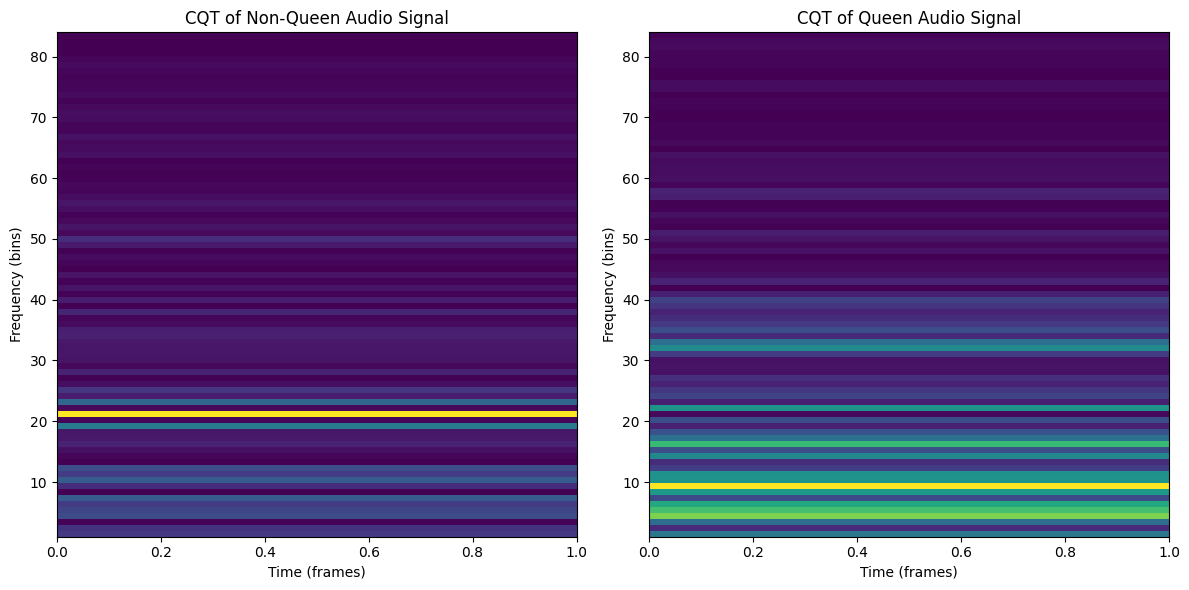

In [9]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def cqt_transform(x, sr, N=1024, K=84):
    """
    Tính toán Constant-Q Transform (CQT) của tín hiệu x.
    
    Args:
    - x: Tín hiệu đầu vào (mảng numpy)
    - sr: Tỷ lệ lấy mẫu (sampling rate)
    - N: Kích thước của tín hiệu (số mẫu) trên mỗi khung
    - K: Số lượng bin tần số (frequency bins)

    Returns:
    - X_cq: CQT của tín hiệu (biến đổi Fourier với tần số logarithmic)
    """
    X_cq = np.zeros((K, len(x)//N))
    
    # Tính toán CQT cho từng khung thời gian
    for n in range(len(x) // N):
        # Tạo cửa sổ CQT với tần số logarithmic
        for k in range(1, K+1):
            window_size = int(N / (2**(k / K)))  # Tính độ rộng cửa sổ cho từng bin tần số
            start = max(n * N - window_size // 2, 0)
            end = min(n * N + window_size // 2, len(x))
            
            # Kiểm tra cửa sổ có hợp lệ không
            if start >= end:
                continue  # Bỏ qua nếu cửa sổ không hợp lệ

            # Chỉ khởi tạo window khi cửa sổ hợp lệ
            window = x[start:end] * np.exp(-2j * np.pi * k * np.arange(len(x[start:end])) / N)
            
            # Tính toán phần thực của CQT
            X_cq[k-1, n] = np.sum(window)
    
    return X_cq

audio_path_nonqueen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

signal_nonqueen, rate_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, rate_queen = librosa.load(audio_path_queen, sr=None)

# Chọn một phần của tín hiệu (ví dụ: 1024 mẫu) cho cả hai tín hiệu
signal_part_nonqueen = signal_nonqueen[:1024]
signal_part_queen = signal_queen[:1024]

# Áp dụng CQT cho cả hai tín hiệu
X_cq_nonqueen = cqt_transform(signal_part_nonqueen, rate_nonqueen)
X_cq_queen = cqt_transform(signal_part_queen, rate_queen)

# Vẽ phổ tần số của CQT cho cả hai tín hiệu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(np.abs(X_cq_nonqueen), aspect='auto', cmap='viridis', origin='lower', extent=[0, len(signal_part_nonqueen)//1024, 1, 84])
ax1.set_title('CQT of Non-Queen Audio Signal')
ax1.set_xlabel('Time (frames)')
ax1.set_ylabel('Frequency (bins)')

ax2.imshow(np.abs(X_cq_queen), aspect='auto', cmap='viridis', origin='lower', extent=[0, len(signal_part_queen)//1024, 1, 84])
ax2.set_title('CQT of Queen Audio Signal')
ax2.set_xlabel('Time (frames)')
ax2.set_ylabel('Frequency (bins)')

plt.tight_layout()
plt.show()


Spectral Contrast (SC)

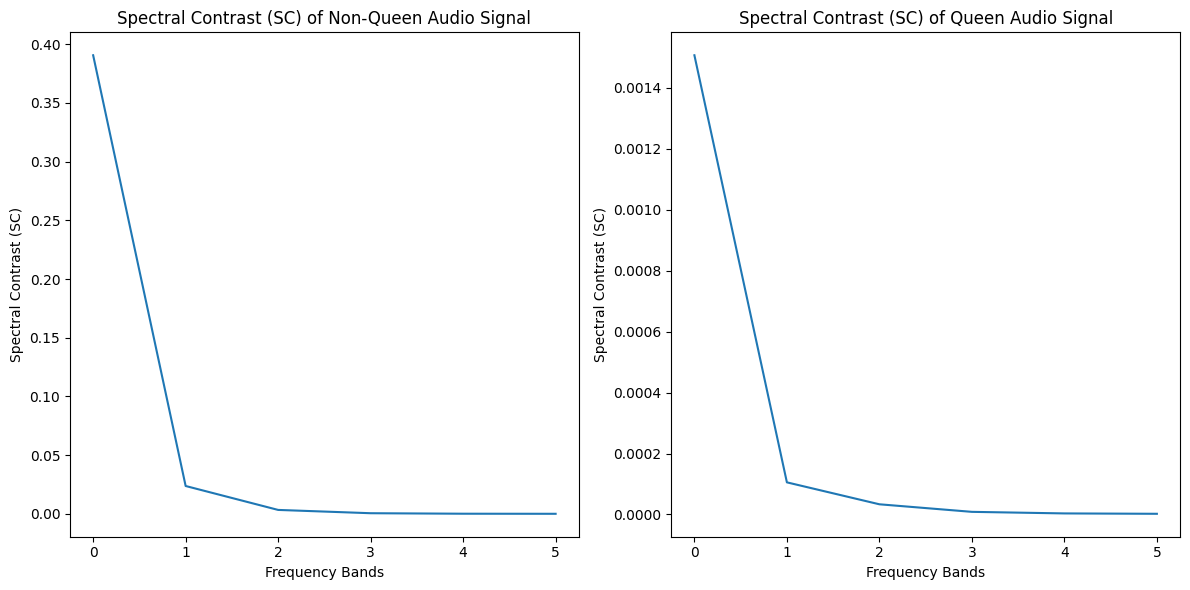

In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def spectral_contrast(x, sr, n_bands=6, fmin=200, fmax=8000, n_fft=2048, hop_length=512):
    """
    Tính toán Spectral Contrast (SC) của tín hiệu x.
    
    Args:
    - x: Tín hiệu âm thanh đầu vào (mảng numpy)
    - sr: Tỷ lệ lấy mẫu (sampling rate)
    - n_bands: Số lượng dải tần số (frequency bands)
    - fmin: Tần số bắt đầu của dải tần số thấp
    - fmax: Tần số kết thúc của dải tần số cao
    - n_fft: Kích thước cửa sổ FFT
    - hop_length: Bước nhảy (hop size) cho FFT
    
    Returns:
    - sc: Spectral Contrast (SC) của tín hiệu
    """
    # Tính toán Mel filter bank
    mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_bands, fmin=fmin, fmax=fmax)
    
    # Tính toán phổ tần số
    D = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    
    # Áp dụng Mel filter bank vào phổ tần số
    mel_spectrum = np.dot(mel_filter, D)
    
    # Tính toán SC: Sự khác biệt giữa đỉnh và đáy trong các dải tần số
    sc = []
    for i in range(n_bands):
        peak = np.max(mel_spectrum[i, :])
        valley = np.min(mel_spectrum[i, :])
        sc.append(peak - valley)
    
    return np.array(sc)

audio_path_nonqueen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

signal_nonqueen, rate_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, rate_queen = librosa.load(audio_path_queen, sr=None)

# Calculate Spectral Contrast for both signals
sc_nonqueen = spectral_contrast(signal_nonqueen, rate_nonqueen)
sc_queen = spectral_contrast(signal_queen, rate_queen)

# Plot Spectral Contrast for both non-queen and queen signals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot SC for non-queen signal
ax1.plot(sc_nonqueen)
ax1.set_title('Spectral Contrast (SC) of Non-Queen Audio Signal')
ax1.set_xlabel('Frequency Bands')
ax1.set_ylabel('Spectral Contrast (SC)')

# Plot SC for queen signal
ax2.plot(sc_queen)
ax2.set_title('Spectral Contrast (SC) of Queen Audio Signal')
ax2.set_xlabel('Frequency Bands')
ax2.set_ylabel('Spectral Contrast (SC)')

plt.tight_layout()
plt.show()


Chroma

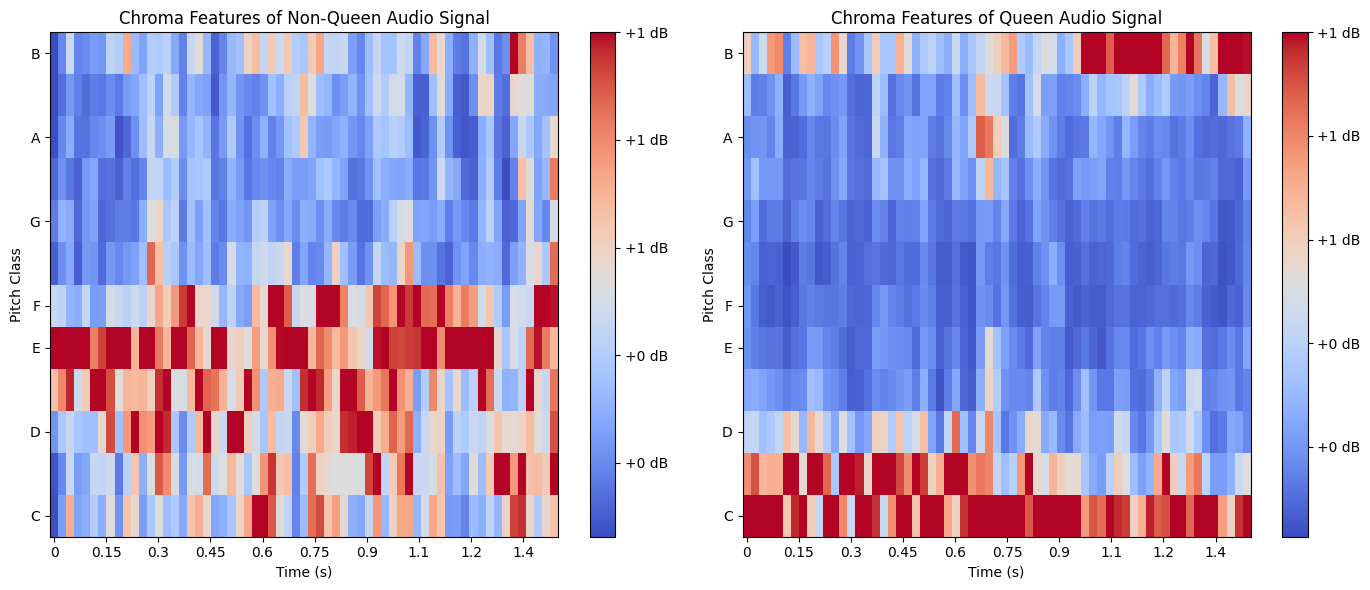

In [12]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_path_nonqueen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen    = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

def chroma_features(x, sr, n_fft=2048, hop_length=512, n_chroma=12):
    """
    Tính toán đặc trưng Chroma của tín hiệu x.
    
    Args:
    - x: Tín hiệu âm thanh đầu vào (mảng numpy)
    - sr: Tỷ lệ lấy mẫu (sampling rate)
    - n_fft: Kích thước cửa sổ FFT
    - hop_length: Bước nhảy (hop size) cho FFT
    - n_chroma: Số lượng lớp âm (pitch classes), thường là 12 (C, C#, D, D#, E, F, F#, G, G#, A, A#, B)
    
    Returns:
    - chroma: Mảng Chroma của tín hiệu âm thanh
    """
    # Tính toán STFT (Short-Time Fourier Transform)
    D = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2

    # Tính toán đặc trưng Chroma
    chroma = librosa.feature.chroma_stft(S=D, sr=sr, n_chroma=n_chroma)

    return chroma

# Tải tín hiệu âm thanh cho NonQueen và Queen
signal_nonqueen, rate_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, rate_queen       = librosa.load(audio_path_queen, sr=None)

# Tính toán đặc trưng Chroma cho từng tín hiệu
chroma_nonqueen = chroma_features(signal_nonqueen, rate_nonqueen)
chroma_queen    = chroma_features(signal_queen, rate_queen)

# Vẽ biểu đồ Chroma cho cả hai tín hiệu theo dạng side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

img1 = librosa.display.specshow(chroma_nonqueen, x_axis='time', y_axis='chroma', cmap='coolwarm', ax=ax1)
fig.colorbar(img1, ax=ax1, format="%+2.f dB")
ax1.set_title("Chroma Features of Non-Queen Audio Signal")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Pitch Class")

img2 = librosa.display.specshow(chroma_queen, x_axis='time', y_axis='chroma', cmap='coolwarm', ax=ax2)
fig.colorbar(img2, ax=ax2, format="%+2.f dB")
ax2.set_title("Chroma Features of Queen Audio Signal")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Pitch Class")

plt.tight_layout()
plt.show()
